In [1]:
import os
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from keras.models import Sequential
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/'
import librosa
import librosa.display
import scipy
import IPython.display as ipd
from scipy import signal
from scipy.io import wavfile

In [2]:
# Open the .csv file with all labels
df = pd.read_csv('./train.csv')

In [3]:
# Show labels
df.head()

,clip_name,label
0,train1.aiff,0
1,train2.aiff,0
2,train3.aiff,0
3,train4.aiff,0
4,train5.aiff,0


In [4]:
# Converting each class name label in a column to a list
df['label']=df['label'].apply(lambda x:str(x).split(',')) #.fillna("")
labels = df['label']

In [5]:
print(labels)

0        [0]
1        [0]
2        [0]
3        [0]
4        [0]
        ... 
29995    [0]
29996    [0]
29997    [0]
29998    [0]
29999    [0]
Name: label, Length: 30000, dtype: object


In [6]:
### Visualising audio clip
audio_fpath = './sample/yes/train12.aiff'
#spectrograms_path = 'D:/03_AAU_Masters/03_3rd_semester/01_project/whale_data/data/train_spectrograms/'
#audio_clips = os.listdir(audio_fpath)

### Loading an audio clip to Librosa
##samples, sample_rate = librosa.load(audio_fpath, sr = None, mono = True, offset = 0.0, duration = None)
## len(samples), sample_rate

# print(type(x), type(sr))
# print(x.shape, sr)
# librosa.load(audio_fpath, sr=44100)

# ### Plotting a wave plot
# plt.figure(figsize=(14, 5))
# librosa.display.waveplot(x, sr=sr)

# ### Plotting a spectrogram
# X = librosa.stft(x)
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
# plt.colorbar()
# y, sr = librosa.load(audio_fpath)
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
# hop_length = 1024
# D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2048, hop_length=hop_length)),
#                             ref=np.max)
# librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
#                          x_axis='time', ax=ax[1])
# ax[1].set(title='Log-frequency power spectrogram')
# ax[1].label_outer()
# fig.colorbar(img, ax=ax, format="%+2.f dB")

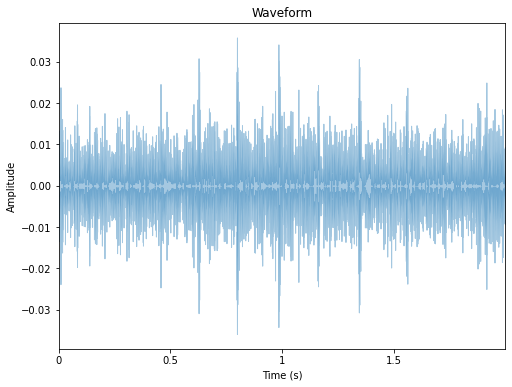

In [7]:
FIG_SIZE = (8,6)
signal, sample_rate = librosa.load(audio_fpath,sr = None) # your data sample rate is 2000 Hz, retrieved from the files
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

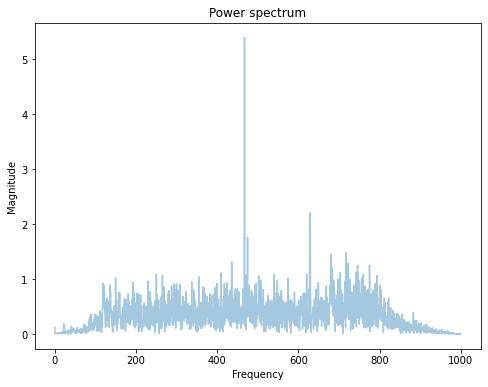

In [8]:
# perform Fourier transform
fft = np.fft.fft(signal)
# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)
# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))
# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]
# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")
plt.show()
# Check, the frequencies go from 0 to FS/2 = 1000.

STFT hop length duration is: 0.064s
STFT window duration is: 1.024s


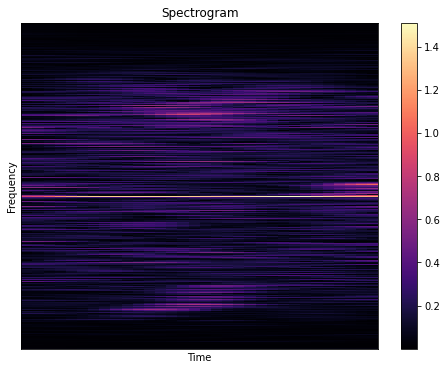

In [13]:
# STFT -> spectrogram
# Figs 3 & 4 say All spectrograms used a sample rate of 250 Hz, 256 point FFT with 85% overlap.
# Your FS = 2000 Hz, 8 times higher
hop_length = 128 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

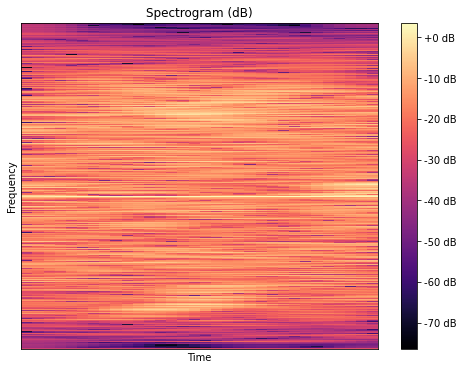

In [14]:
# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()

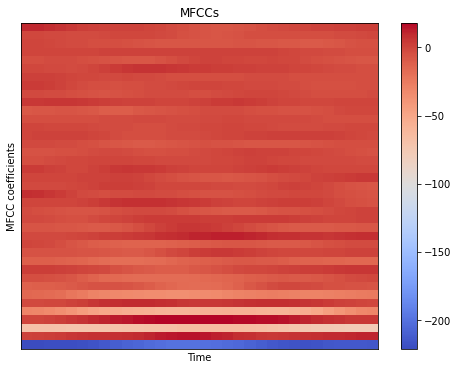

In [15]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft,
hop_length=hop_length, n_mfcc=39)
# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate,
hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
plt.show()

In [16]:
def generate_spectrogram(x, sr, save_name):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig = plt.figure(figsize=(20, 20), dpi=1000, frameon=False)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.axis('off')
    librosa.display.specshow(Xdb, sr=sr, cmap='gray', x_axis='time', y_axis='log')
    plt.savefig(save_name, pil_kwargs={'quality': 95}, bbox_inches=0, pad_inches=0)
    librosa.cache.clear()

for i in audio_clips:
    audio_fpath = "D:/03_AAU_Masters/03_3rd_semester/01_project/whale_data/data/sample/yes/"
    spectrograms_path = "D:/03_AAU_Masters/03_3rd_semester/01_project/whale_data/data/train_spectrograms/"
    audio_length = librosa.get_duration(filename=audio_fpath + i)
    x, sr = librosa.load(audio_fpath + i)
    save_name = spectrograms_path + i + ".jpg"
    generate_spectrogram(x, sr, save_name)

NameError: name 'audio_clips' is not defined

In [26]:
img.shape()
# Transforming images
# datagen=ImageDataGenerator(rescale=1./255.)
# test_datagen=ImageDataGenerator(rescale=1./255.)

AttributeError: 'QuadMesh' object has no attribute 'shape'

In [13]:
# Splitting the data for training and defining classes
train_generator=datagen.flow_from_dataframe(
dataframe=df[0],
directory= data,
x_col='clip_name',
y_col='label',
batch_size=32,
seed=42,
shuffle=True,
class_mode='categorical',
color_mode='grayscale',
classes=['0', '1'],
target_size=(129,500))

KeyError: 0

In [10]:
# Splitting the data for validation and defining classes
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[32000:34000],
directory='/content/drive/MyDrive/Colab Notebooks/imgs.zip (Unzipped Files)/imgs',
x_col='File',
y_col='Label',
batch_size=32,
seed=42,
shuffle=True,
class_mode='categorical',
color_mode='grayscale',
classes=['Noise', 'GLGN', 'MEKE', 'AEAC', 'STVA', 'BUVI', 'STOC'],
target_size=(129,500))

Found 2000 validated image filenames belonging to 7 classes.


In [11]:
# Splitting the data for testing
test_generator=test_datagen.flow_from_dataframe(
dataframe=df[100000:102000],
directory='/content/drive/MyDrive/Colab Notebooks/imgs.zip (Unzipped Files)/imgs',
x_col='File',
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
color_mode='grayscale',
target_size=(129,500))

Found 2000 validated image filenames.


In [14]:
# Initialising the model
model = Sequential()

# Adding the Convolutional layer
model.add(Conv2D(32, (3,3), input_shape = (129,500,1), activation=activations.relu))
# Adding the Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Adding the Convolutional layer
model.add(Conv2D(32, (3,3), activation=activations.relu))
# Adding the Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Implementing dropout
model.add(Dropout(0.2))

# Adding the Convolutional layer
model.add(Conv2D(64, (3,3), activation=activations.relu))
# Adding the Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Implementing dropout
model.add(Dropout(0.2))
 
# Adding the Convolutional layer
model.add(Conv2D(64, (3,3), activation=activations.relu))
# Adding the Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Implementing dropout
model.add(Dropout(0.2))

# Adding the Flattening data 
model.add(Flatten())

# Adding a fully conected layer
model.add(Dense(64, activation=activations.relu))
# Implementing dropout
model.add(Dropout(0.5))

# Adding a fully conected layer
model.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Applying an optimizing algorithm
adam = keras.optimizers.Adam(lr=0.0001)

# Running the model
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Fitting the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
311/311 [==============================] - 4045s 13s/step - loss: 1.3505 - accuracy: 0.5460 - val_loss: 0.7845 - val_accuracy: 0.8286
Epoch 2/30
311/311 [==============================] - 790s 3s/step - loss: 0.8519 - accuracy: 0.7808 - val_loss: 0.7742 - val_accuracy: 0.8211
Epoch 3/30
311/311 [==============================] - 790s 3s/step - loss: 0.7916 - accuracy: 0.7790 - val_loss: 0.7518 - val_accuracy: 0.8518
Epoch 4/30
311/311 [==============================] - 794s 3s/step - loss: 0.7239 - accuracy: 0.7940 - val_loss: 0.6966 - val_accuracy: 0.8523
Epoch 5/30
311/311 [==============================] - 791s 3s/step - loss: 0.5689 - accuracy: 0.8207 - val_loss: 0.5108 - val_accuracy: 0.9178
Epoch 6/30
311/311 [==============================] - 791s 3s/step - loss: 0.4380 - accuracy: 0.8760 - val_loss: 0.4716 - val_accuracy: 0.9219
Epoch 7/30
311/311 [==============================] - 790s 3s/step - loss: 0.3630 - accuracy: 0.9072 - val_loss: 0.4329 - val_accuracy: 0.92

In [16]:
# Save the model to disk.
model.save_weights('owls-cnn7.h5')

In [17]:
# Resetting the generator
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

2000/2000 [==============================] - 927s 464ms/step


In [18]:
pred_bool = (pred > 0.5)

In [21]:
#acting like a test_generator, batch_size should be 1
model.evaluate(valid_generator, steps=STEP_SIZE_VALID) 

predictions=[]
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

62/62 [==============================] - 37s 597ms/step - loss: 469.6106 - accuracy: 0.9204


In [24]:
df = pd.read_csv('results.csv')

In [25]:
print(df)

                                     Filename Predictions
0     COA_9580-5_20180514_065002_part_201.png       Noise
1     COA_9580-5_20180514_065002_part_216.png       Noise
2     COA_9580-5_20180514_065002_part_217.png       Noise
3     COA_9580-5_20180514_065002_part_218.png       Noise
4     COA_9580-5_20180514_065002_part_219.png       Noise
...                                       ...         ...
1995  COA_9580-5_20180520_064402_part_069.png       Noise
1996  COA_9580-5_20180520_064402_part_082.png       Noise
1997  COA_9580-5_20180520_064402_part_087.png       Noise
1998  COA_9580-5_20180520_064402_part_088.png       Noise
1999  COA_9580-5_20180520_064402_part_100.png       Noise

[2000 rows x 2 columns]


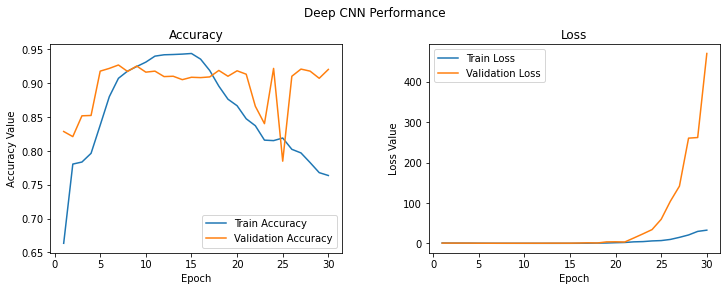

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Deep CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")